In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wrds
import os
import warnings
warnings.filterwarnings('ignore')
import duckdb
import fastparquet
from scipy import stats
import statsmodels.iolib.summary2 as sm_summary

from IPython.display import HTML


In [2]:
if os.path.exists('/Users/ethan/Documents/HKU/Quantitative Trading/quant_2025_public/data') == True:
    data_folder = '/Users/ethan/Documents/HKU/Quantitative Trading/quant_2025_public/data'
    os.chdir(data_folder)   
else:
    print('invalid data path!')

# Fetch Data

### **S&P500**

In [3]:
conn = wrds.Connection(wrds_username='ethanchen2277')
crsp_dsp500 = conn.raw_sql("""
    SELECT 
    caldt AS date,
    vwretd AS ret
    FROM crsp.dsp500
    WHERE caldt BETWEEN '1995-07-01' AND '2023-12-31'
""")
conn.close()
crsp_dsp500['date'] = pd.to_datetime(crsp_dsp500['date'])
crsp_dsp500.head()

Loading library list...
Done


,date,ret
0,1995-07-03,0.004382
1,1995-07-05,0.000756
2,1995-07-06,0.012591
3,1995-07-07,0.004334
4,1995-07-10,0.001181


### **CRSP**

In [4]:
con = duckdb.connect()

query = ("""
    WITH
    crsp_d AS (
        SELECT
            crsp.permno,
            CAST(crsp.dlycaldt AS DATE) AS date,
            crsp.dlyprc AS price,
            crsp.dlyret AS ret,
            crsp.shrout AS shares_outstanding,
            (crsp.shrout * crsp.dlyprc) AS market_cap,
            crsp.dlybid AS bid,
            crsp.dlyask AS ask,
            crsp.dlyvol AS volume,
            crsp.dlyprcvol AS price_volume,
            crsp.dlyhigh AS high,
            crsp.dlylow AS low,
            dse.exchcd,
            dse.shrcd
        FROM read_parquet('crsp_202401.dsf_v2.parquet') crsp
        LEFT JOIN read_parquet('crsp_202401.dsenames.parquet') dse
            ON crsp.permno = dse.permno
            AND crsp.dlycaldt BETWEEN dse.namedt AND COALESCE(dse.nameendt, '9999-12-31')
            AND dse.namedt IS NOT NULL
        WHERE crsp.dlycaldt BETWEEN '1995-07-01' AND '2023-12-31'
        AND exchcd IN (1, 2, 3)
        AND shrcd IN (10, 11)
),
month_end AS (
    SELECT 
        permno,
        LAST_DAY(LAST(date)) AS month_end_date,
        LAST(market_cap) AS lagged_mktcap
    FROM crsp_d
    WHERE market_cap IS NOT NULL
    GROUP BY permno, EXTRACT(YEAR FROM date), EXTRACT(MONTH FROM date)
)
SELECT 
    crsp_d.*,
    m.lagged_mktcap as mcap_l1,
FROM crsp_d
LEFT JOIN month_end m
ON crsp_d.permno = m.permno
AND m.month_end_date = LAST_DAY(crsp_d.date - INTERVAL 1 MONTH)
WHERE mcap_l1 IS NOT NULL
""")

crsp_d = con.execute(query).fetch_df()

con.close()

crsp_d.head()

,permno,date,price,ret,shares_outstanding,market_cap,bid,ask,volume,price_volume,high,low,exchcd,shrcd,mcap_l1
0,14441,2019-11-01,10.30,0.010795,10952,112805.60,10.26,10.29,54840.0,564852.0,10.4700,10.19,3,11,111600.88
1,14441,2019-11-04,9.95,-0.033981,10952,108972.40,9.88,9.96,52456.0,521937.2,10.4700,9.88,3,11,111600.88
2,14441,2019-11-05,9.90,-0.005025,10952,108424.80,9.85,9.92,22889.0,226601.1,10.0350,9.75,3,11,111600.88
3,14441,2019-11-06,8.94,-0.096970,10952,97910.88,8.93,8.95,112532.0,1006036.1,9.9100,8.82,3,11,111600.88
4,14441,2019-11-07,9.49,0.061521,10952,103934.48,9.48,9.58,80506.0,764001.9,10.0499,9.02,3,11,111600.88


### **Liquidity**

In [5]:
con = duckdb.connect()
vw_query= """
WITH 
illiq AS (
    -- Compute the daily Amihud illiquidity measure.
    SELECT 
        permno,
        date,
        ABS(ret) / NULLIF(price_volume, 0) * 1e6 AS illiq_daily
    FROM crsp_d
    WHERE volume >= 100
)
-- Compute the rolling one-year (252-day) average illiquidity using a window function.
SELECT 
    permno,
    date,
    AVG(illiq_daily) OVER (
        PARTITION BY permno 
        ORDER BY date 
        ROWS BETWEEN 251 PRECEDING AND CURRENT ROW
    ) AS illiq
FROM illiq
"""
illiq_df = con.execute(vw_query).fetch_df()
illiq_df['date'] = pd.to_datetime(illiq_df['date'])
illiq_df.head()

,permno,date,illiq
0,83254,1998-03-26,0.557823
1,83254,1998-03-27,0.558548
2,83254,1998-03-30,0.558653
3,83254,1998-03-31,0.558611
4,83254,1998-04-01,0.554116


### **CRSP VW Portfoluio**

In [6]:
con = duckdb.connect()

vw_query= """
WITH
merged_data AS (
    SELECT 
        crsp.*,
        i.illiq
    FROM crsp_d crsp
    LEFT JOIN illiq_df i
    ON crsp.permno = i.permno
    AND i.date = crsp.date
)
SELECT
    date,
    SUM(ret * mcap_l1) / NULLIF(SUM(mcap_l1), 0) AS ret,
    SUM(illiq * mcap_l1) / NULLIF(SUM(mcap_l1), 0) AS illiq
FROM merged_data
WHERE mcap_l1 IS NOT NULL
AND ret IS NOT NULL
GROUP BY date
ORDER BY date
"""

vw_returns = con.execute(vw_query).fetch_df()
vw_returns['date'] = pd.to_datetime(vw_returns['date'])
vw_returns.head()

,date,ret,illiq
0,1995-08-01,-0.004858,0.074747
1,1995-08-02,-0.001937,0.058384
2,1995-08-03,-0.000895,0.063041
3,1995-08-04,0.001765,0.067127
4,1995-08-07,0.002691,0.081519


### **Liquidity Portfolio**

In [7]:
con = duckdb.connect()

query = """
WITH illiq_bin AS (
    SELECT 
        date,
        permno,
        NTILE(10) OVER (
            PARTITION BY EXTRACT(MONTH FROM date) 
            ORDER BY illiq) AS bin
    FROM illiq_df
),
portfolio_ret AS (
    SELECT 
        crsp.date,
        bin,
        -- Equal-weighted portfolio returns
        AVG(ret) as portfolio_ew,
        -- Value-weighted portfolio returns
        SUM(ret * mcap_l1) / SUM(mcap_l1) as portfolio_vw
    FROM crsp_d crsp
    LEFT JOIN illiq_bin i
    ON crsp.permno = i.permno
    AND crsp.date = i.date
    GROUP BY crsp.date, bin
    ORDER BY crsp.date, bin
)
SELECT 
    *
FROM portfolio_ret
"""

liq_portfolio = con.execute(query).fetch_df()
liq_portfolio['date'] = pd.to_datetime(liq_portfolio['date'])
liq_portfolio.head()

,date,bin,portfolio_ew,portfolio_vw
0,1995-08-01,1.0,-0.000264,-0.003442
1,1995-08-01,2.0,-0.005809,-0.009536
2,1995-08-01,3.0,-0.002757,-0.001699
3,1995-08-01,4.0,-0.002270,-0.003388
4,1995-08-01,5.0,-0.005604,-0.006758


### **Macro News**

In [8]:
# loading the CPI data
cpi = pd.read_excel('CPI.xlsx')
cpi = cpi[cpi['Event']== 'CPI MoM'].sort_values('Date Time')
# keep only the date
cpi['date'] = pd.to_datetime(cpi['Date Time']).dt.date
# Retain only the relevant columns and drop duplicates
cpi = cpi[['date', 'Actual', 'Survey']].drop_duplicates()
# rename the columns
cpi = cpi.rename(columns={
    'Survey': 'Survey_Value',
    'Actual': 'Actual_Value'
})
# add the announcement type
cpi['Announcement_Type'] = 'CPI'

# loading the FOMC data
FOMC = pd.read_excel('FOCM.xlsx')
FOMC = FOMC[FOMC['Event']== 'FOMC Rate Decision (Upper Bound)'].sort_values('Date Time')
FOMC['date'] = pd.to_datetime(FOMC['Date Time']).dt.date
FOMC = FOMC[['date', 'Actual', 'Surv(M)', 'Surprise']].drop_duplicates()
FOMC = FOMC.rename(columns={
    'Surv(M)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
FOMC['Announcement_Type'] = 'FOMC'

# loading the unemployment data
unemployment = pd.read_excel('Unemployment.xlsx')
unemployment = unemployment[unemployment['Event']== 'Unemployment Rate'].sort_values('Date Time')
unemployment['date'] = pd.to_datetime(unemployment['Date Time']).dt.date
unemployment = unemployment[['date', 'Actual', 'Surv(M)', 'Surprise']].drop_duplicates()
unemployment = unemployment.rename(columns={
    'Surv(M)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
unemployment['Announcement_Type'] = 'Unemployment'

In [9]:
# Combine all macro announcements
macro_announcements = pd.concat([cpi, FOMC, unemployment])

# Create dummy variables for each announcement type
macro_dummies = pd.get_dummies(macro_announcements, 
                               columns=['Announcement_Type'],
                               prefix='',
                               prefix_sep='')

macro_dummies['date'] = pd.to_datetime(macro_dummies['date'])

macro_dummies.head()

,date,Actual_Value,Survey_Value,Surprise,CPI,FOMC,Unemployment
0,1996-12-12,0.003,0.003,NaN,True,False,False
2,1997-01-15,0.003,0.003,NaN,True,False,False
5,1997-02-20,0.001,0.003,NaN,True,False,False
7,1997-03-20,0.003,0.002,NaN,True,False,False
9,1997-04-16,0.001,0.003,NaN,True,False,False


# Replication

In [10]:
is_period = pd.date_range(start='1995-07-01', end='2013-12-31', freq='D')
oos_period = pd.date_range(start='2014-01-01', end='2023-12-31', freq='D')

In [11]:
# Identify Trading Days Relative to Month End
# label trading days relative to month end

def label_trading_days(df):
    df = df.sort_values('date')
    df['month'] = df['date'].dt.to_period('M')
    
    # Initialize trading day labels
    df['trading_day'] = np.nan
    
    for month in df['month'].unique():
        month_data = df[df['month'] == month]
        n_days = len(month_data)
        
        for i, idx in enumerate(month_data.index):
            days_to_end = n_days - i - 1
            if days_to_end <= 8:
                df.loc[idx, 'trading_day'] = -days_to_end
            
        next_month_data = df[df['month'] == month + 1]
        for i, idx in enumerate(next_month_data.index[:8]):
            df.loc[idx, 'trading_day'] = i + 1
            
    return df

def label_periods(df, periods_dict=None):
    """
    Label trading days with periods based on a dictionary of period specifications.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame containing 'trading_day' column
    periods_dict : dict, optional
        Dictionary specifying periods in format:
        {period_name: (start_day, end_day)}
        If None, uses default event study periods
        
    Returns:
    --------
    DataFrame with added 'period' column
    """
    df = df.copy()
    
    # Default periods if none specified
    if periods_dict is None:
        periods_dict = {
            'T-8_to_T-4': (-8, -4),
            'T-3_to_T-1': (-3, -1),
            'T': (0, 0),
            'T+1_to_T+3': (1, 3),
            'T+4_to_T+8': (4, 8)
        }
    
    # Initialize all periods as 'other'
    df['period'] = 'other'
    
    # Label each period according to the dictionary
    for period_name, (start_day, end_day) in periods_dict.items():
        if start_day == end_day:
            df.loc[df['trading_day'] == start_day, 'period'] = period_name
        else:
            df.loc[df['trading_day'].between(start_day, end_day), 'period'] = period_name
            
    return df

def get_period_stats(daily_returns):
    df = daily_returns.copy()
    
    # get average returns by period
    period_stats = df.groupby('period')['ret'].agg(['mean', 'std', 'count'])

    # compute abnormal returns
    period_stats['t_stat'] = (period_stats['mean'] * np.sqrt(period_stats['count']) / 
                             period_stats['std'])
    period_stats['p_value'] = 2 * (1 - stats.t.cdf(abs(period_stats['t_stat']), 
                                              period_stats['count'] - 1))
    
    # Compute overall statistics for daily returns.
    overall_stats = daily_returns['ret'].agg(['mean', 'std', 'count'])
    
    # Calculate the t-statistic for the daily returns.
    if overall_stats['std'] != 0:
        t_stat_daily = overall_stats['mean'] / (overall_stats['std'] / np.sqrt(overall_stats['count']))
        p_value_daily = 2 * (1 - stats.t.cdf(np.abs(t_stat_daily), overall_stats['count'] - 1))
    else:
        t_stat_daily = np.nan
        p_value_daily = np.nan
        
    overall_stats['t_stat'] = t_stat_daily
    overall_stats['p_value'] = p_value_daily
    
    # Convert the overall stats Series to a DataFrame with a single row.
    overall_stats_df = pd.DataFrame(overall_stats).T
    overall_stats_df.index = ['Average Daily Return']
    
    # Combine period stats and the overall daily stats.
    combined_stats = pd.concat([period_stats, overall_stats_df])
    return combined_stats

def plot_period_returns(daily_returns, plot_title):
    # plot the graph
    plt.figure(figsize=(15, 8))
    daily_means = daily_returns.groupby('trading_day')['ret'].mean()

    # plt.plot(daily_means.index, daily_means.values, marker='o')
    plt.bar(daily_means.index, daily_means.values, color='grey', alpha=0.7)
    plt.axhline(y=daily_returns['ret'].mean(), color='r', linestyle='--', label='Average Daily Return')
    plt.axvline(x=-3.5, color='b', linestyle='--', label='T-4')
    plt.axvline(x=4, color='b', linestyle='--', label='T+3')
    
    plt.title(plot_title)
    x_ticks = range(int(min(daily_means.index)), int(max(daily_means.index))+1)
    plt.xticks(x_ticks)
    plt.xlabel('Trading Days Relative to Month End (T=0)')
    plt.ylabel('Average Return')
    plt.legend()
    plt.grid(True)
    plt.show()


**in-sample test for crsp value-weighted index**

                          mean       std   count    t_stat   p_value
T                     0.000310  0.011570   221.0  0.397909  0.691083
T+1_to_T+3            0.001262  0.012921   660.0  2.510108  0.012308
T+4_to_T+8           -0.000254  0.012588  1098.0 -0.669185  0.503518
T-3_to_T-1            0.001271  0.012743   663.0  2.568691  0.010426
T-8_to_T-4           -0.000339  0.012488  1105.0 -0.902248  0.367122
other                 0.001130  0.013057   891.0  2.583381  0.009942
Average Daily Return  0.000452  0.012694  4638.0  2.426478  0.015284


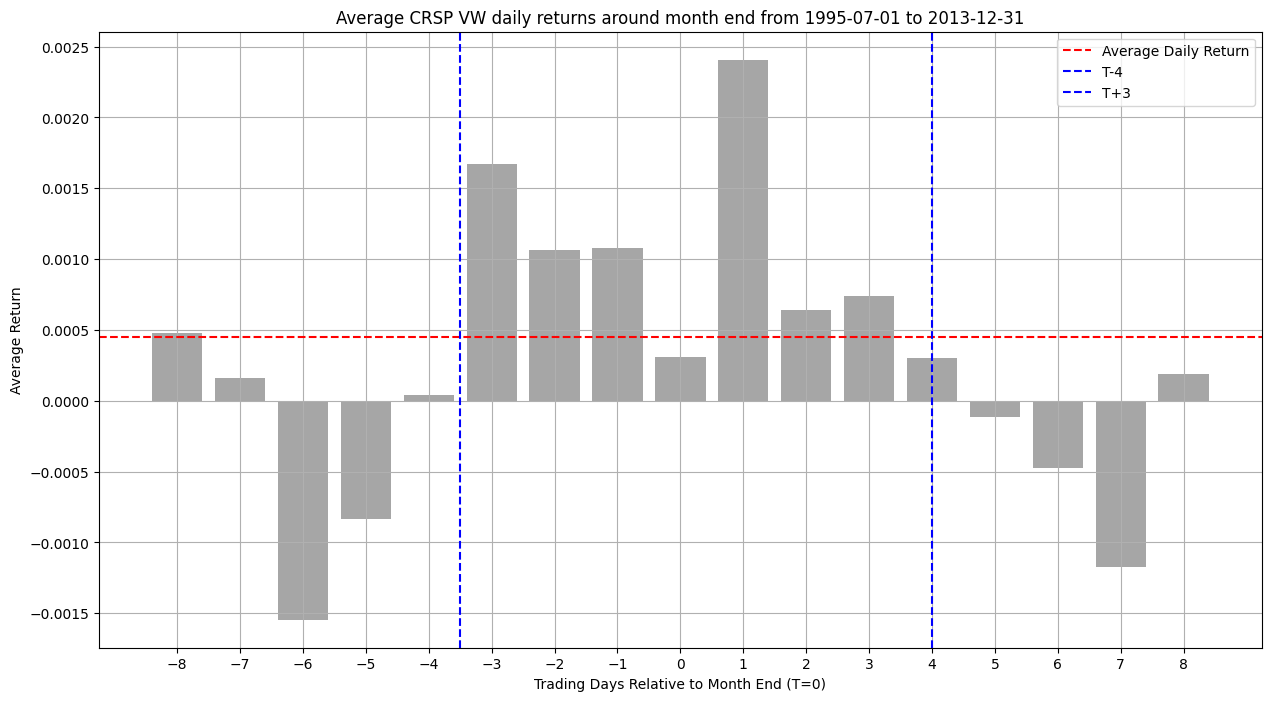

In [12]:
vw_is = vw_returns[vw_returns['date'].isin(is_period)]
vw_is = label_trading_days(vw_is)
vw_is = label_periods(vw_is)
vw_period_stats_is = get_period_stats(vw_is)
print(vw_period_stats_is)
plot_period_returns(vw_is, 'Average CRSP VW daily returns around month end from 1995-07-01 to 2013-12-31')

**out-of-sample test forcrsp value-weighted index**

                          mean       std   count    t_stat   p_value
T                    -0.000582  0.009787   120.0 -0.651945  0.515694
T+1_to_T+3            0.000939  0.011366   357.0  1.560969  0.119420
T+4_to_T+8            0.000481  0.011457   595.0  1.023565  0.306457
T-3_to_T-1            0.001353  0.011446   360.0  2.243144  0.025497
T-8_to_T-4           -0.000097  0.010639   600.0 -0.222479  0.824017
other                 0.000646  0.013360   484.0  1.064431  0.287665
Average Daily Return  0.000514  0.011577  2516.0  2.227264  0.026018


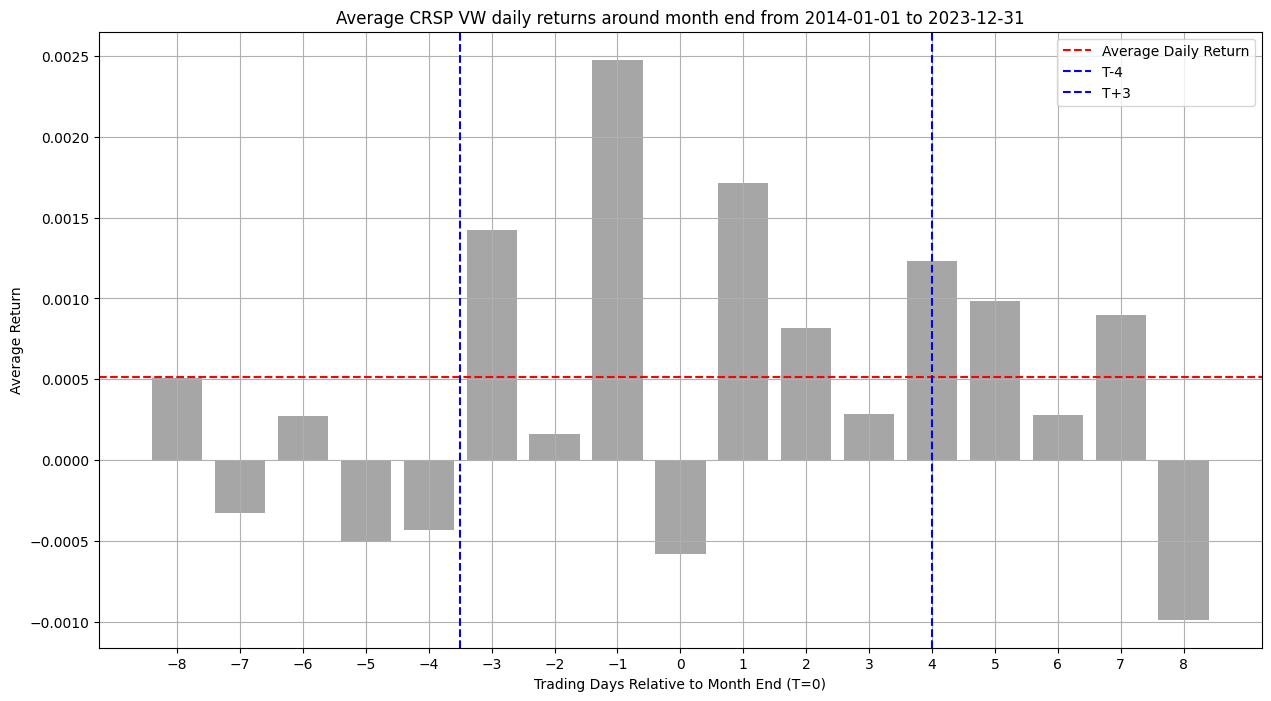

In [13]:
vw_oos = vw_returns[vw_returns['date'].isin(oos_period)]
vw_oos = label_trading_days(vw_oos)
vw_oos = label_periods(vw_oos)
vw_period_stats_oos = get_period_stats(vw_oos)
print(vw_period_stats_oos)
plot_period_returns(vw_oos, 'Average CRSP VW daily returns around month end from 2014-01-01 to 2023-12-31')

**in-sample test for sp500**

                          mean       std   count    t_stat   p_value
T                    -0.000401  0.011532   222.0 -0.518724  0.604472
T+1_to_T+3            0.001351  0.012664   663.0  2.747693  0.006165
T+4_to_T+8           -0.000234  0.012355  1103.0 -0.629315  0.529273
T-3_to_T-1            0.001092  0.012598   666.0  2.237688  0.025572
T-8_to_T-4           -0.000365  0.012278  1110.0 -0.990672  0.322062
other                   0.0012  0.012889   894.0  2.783587  0.005490
Average Daily Return  0.000417  0.012499  4658.0  2.278423  0.022746


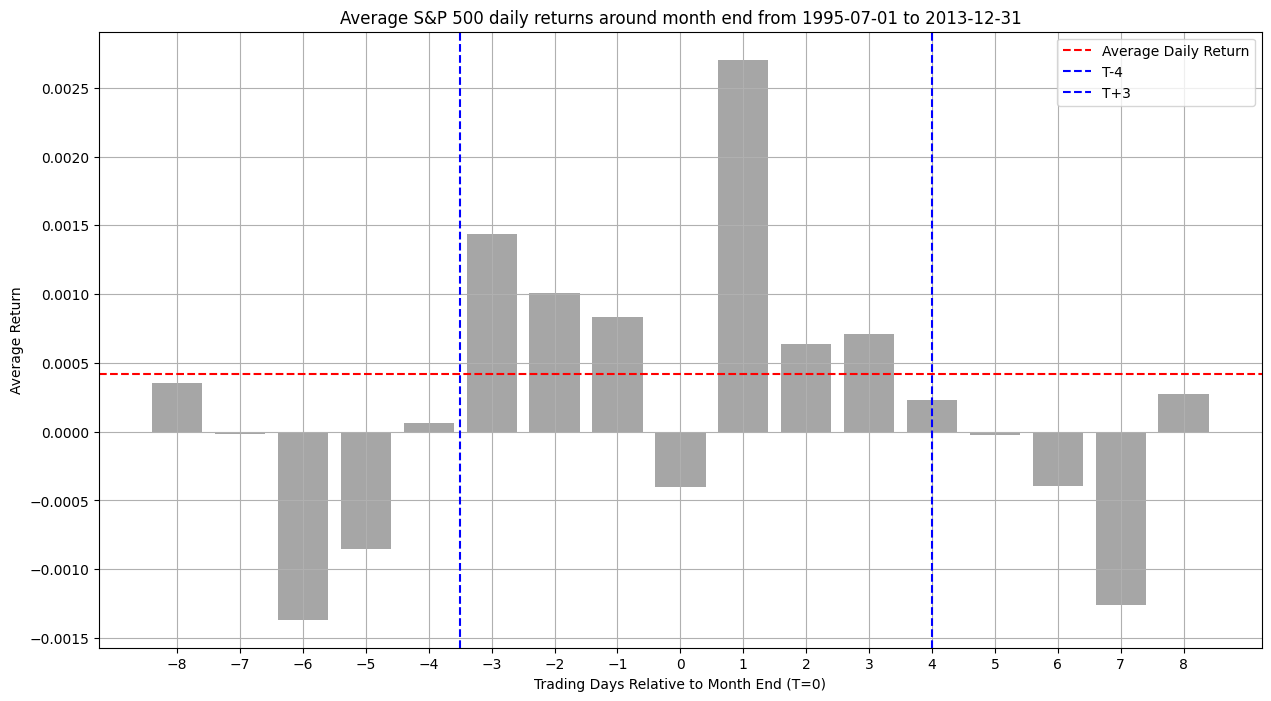

In [14]:
sp500_is = crsp_dsp500[crsp_dsp500['date'].isin(is_period)]
sp500_is = label_trading_days(sp500_is)
sp500_is = label_periods(sp500_is)
sp500_period_stats_is = get_period_stats(sp500_is)
print(sp500_period_stats_is)
plot_period_returns(sp500_is, 'Average S&P 500 daily returns around month end from 1995-07-01 to 2013-12-31')

**out-of-sample test for sp500**

                          mean       std   count    t_stat   p_value
T                    -0.000728  0.009493   120.0 -0.840605  0.402255
T+1_to_T+3            0.001012  0.010987   357.0  1.740155  0.082696
T+4_to_T+8            0.000528  0.010994   595.0  1.171069  0.242041
T-3_to_T-1            0.001359  0.011149   360.0   2.31278  0.021300
T-8_to_T-4           -0.000173  0.010158   600.0 -0.417715  0.676305
other                 0.000662  0.012896   484.0  1.129403  0.259289
Average Daily Return  0.000514  0.011157  2516.0  2.311475  0.020887


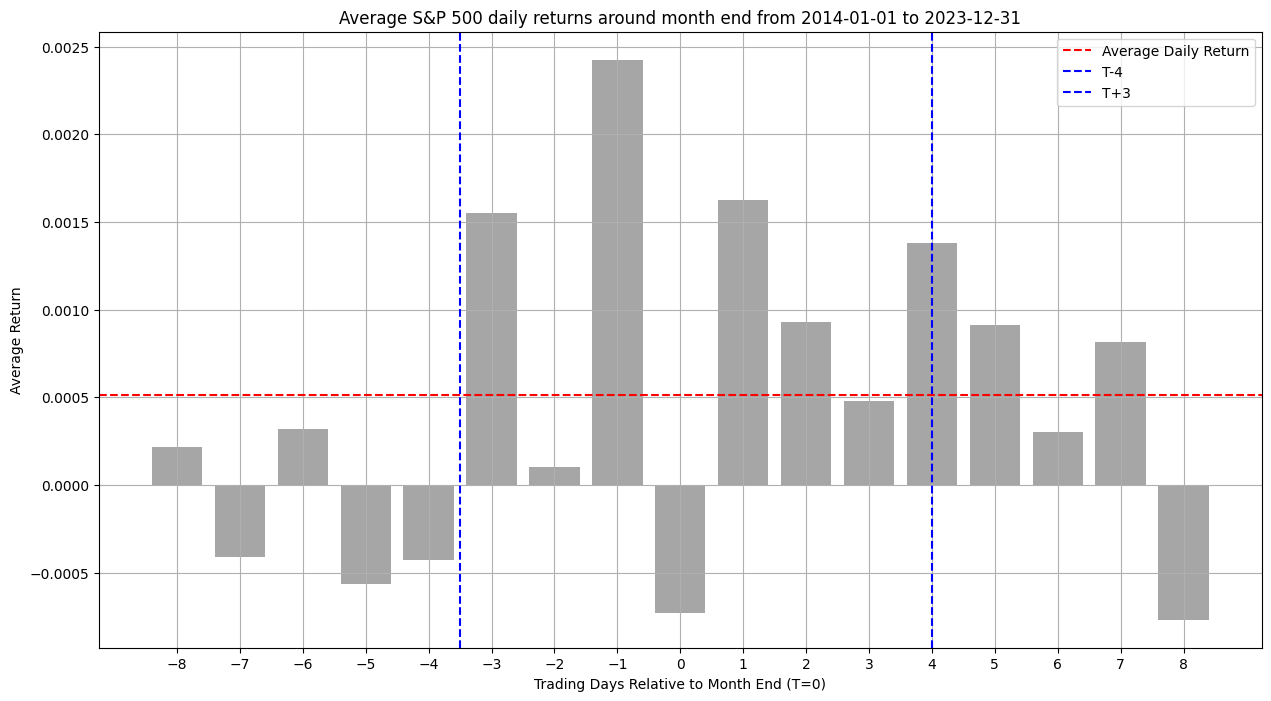

In [15]:
sp500_oos = crsp_dsp500[crsp_dsp500['date'].isin(oos_period)]
sp500_oos = label_trading_days(sp500_oos)
sp500_oos = label_periods(sp500_oos)
sp500_period_stats_oos = get_period_stats(sp500_oos)
print(sp500_period_stats_oos)
plot_period_returns(sp500_oos, 'Average S&P 500 daily returns around month end from 2014-01-01 to 2023-12-31')

In [16]:
def format_value(val, p_val, significance_threshold=0.05):
    """
    Multiply the value by 100 and format to two decimal places with a percentage sign.
    If the p-value is below the significance threshold, wrap the result in <strong> HTML tags.
    """
    formatted = f"{val * 100:.2f}%"
    if p_val < significance_threshold:
        return f"<strong>{formatted}</strong>"
    return formatted

def combine_stats_tables(stats_dict, ordered_periods=None):
    """
    Combine multiple statistic DataFrames into one HTML formatted table (as a DataFrame)
    with separate rows for 'mean' and 't_stat'. Each numeric value is shown in percentage
    (multiplied by 100), rounded to two decimals.
    
    Parameters:
        stats_dict: dict
            A dictionary where each key is a tuple (sample_period, index_name) and each value
            is a DataFrame with period labels as its index and columns including 'mean', 't_stat',
            and 'p_value'. The row labeled 'other' will be dropped.
        ordered_periods: list (optional)
            The list defining the desired order of period columns.
    
    Returns:
        combined_df: DataFrame
            A DataFrame with a MultiIndex (Sample Period, Index Name, Metric) and HTML formatted
            cells (with <strong> tags for values that are significant).
    """
    # Default order for columns if not provided.
    if ordered_periods is None:
        ordered_periods = ["T-8_to_T-4", "T-3_to_T-1", "T_0", "T+1_to_T+3", "T+4_to_T+8"]

    combined_data = {}
    for (sample_period, index_name), df in stats_dict.items():
        # Drop 'other' row if it exists.
        df = df.drop(index=['other'], errors='ignore')
        for metric in ["mean", "t_stat"]:
            row_data = {}
            for period in ordered_periods:
                if period in df.index:
                    val = df.loc[period, metric]
                    p_val = df.loc[period, 'p_value']
                    row_data[period] = format_value(val, p_val)
                else:
                    row_data[period] = ""
            combined_data[(sample_period, index_name, metric)] = row_data
    combined_df = pd.DataFrame.from_dict(combined_data, orient="index", columns=ordered_periods)
    combined_df.index = pd.MultiIndex.from_tuples(
        combined_df.index, names=["Sample Period", "Index Name", "Metric"]
    )
    return combined_df.sort_index()

In [17]:
# Prepare the dictionary of statistic tables.
combine_stats = {
    ("in-sample", "CRSP VW"): vw_period_stats_is,
    ("out-of-sample", "CRSP VW"): vw_period_stats_oos,
    ("in-sample", "S&P 500"): sp500_period_stats_is,
    ("out-of-sample", "S&P 500"): sp500_period_stats_oos
}

# Specify the desired period order.
ordered_periods = ["T-8_to_T-4", "T-3_to_T-1", "T", "T+1_to_T+3", "T+4_to_T+8", "Average Daily Return"]

final_table = combine_stats_tables(combine_stats, ordered_periods)

# Display the final table as HTML in the Jupyter Notebook.
display(HTML(final_table.to_html(escape=False)))

# Some trials
## Looking at different settlement days period

In [18]:
tp3_period = pd.date_range(start='1995-07-01', end='2017-09-30', freq='D')
tp2_period = pd.date_range(start='2017-10-01', end='2023-12-31', freq='D')

In [19]:
periods_dict = {
            'T-8_to_T-4': (-8, -4),
            'T-3': (-3, -3),
            'T-2': (-2, -2),
            'T-1': (-1, -1),
            'T': (0, 0),
            'T+1_to_T+3': (1, 3),
            'T+4_to_T+8': (4, 8)
        }

vw_tp2 = vw_returns[vw_returns['date'].isin(tp2_period)]
vw_tp2 = label_trading_days(vw_tp2)
vw_tp2 = label_periods(vw_tp2, periods_dict)
vw_period_stats_tp2 = get_period_stats(vw_tp2)

vw_tp3 = vw_returns[vw_returns['date'].isin(tp3_period)]
vw_tp3 = label_trading_days(vw_tp3)
vw_tp3 = label_periods(vw_tp3)
vw_period_stats_tp3 = get_period_stats(vw_tp3)

sp500_tp2 = crsp_dsp500[crsp_dsp500['date'].isin(tp2_period)]
sp500_tp2 = label_trading_days(sp500_tp2)
sp500_tp2 = label_periods(sp500_tp2, periods_dict)
sp500_period_stats_tp2 = get_period_stats(sp500_tp2)

sp500_tp3 = crsp_dsp500[crsp_dsp500['date'].isin(tp3_period)]
sp500_tp3 = label_trading_days(sp500_tp3)
sp500_tp3 = label_periods(sp500_tp3)
sp500_period_stats_tp3 = get_period_stats(sp500_tp3)

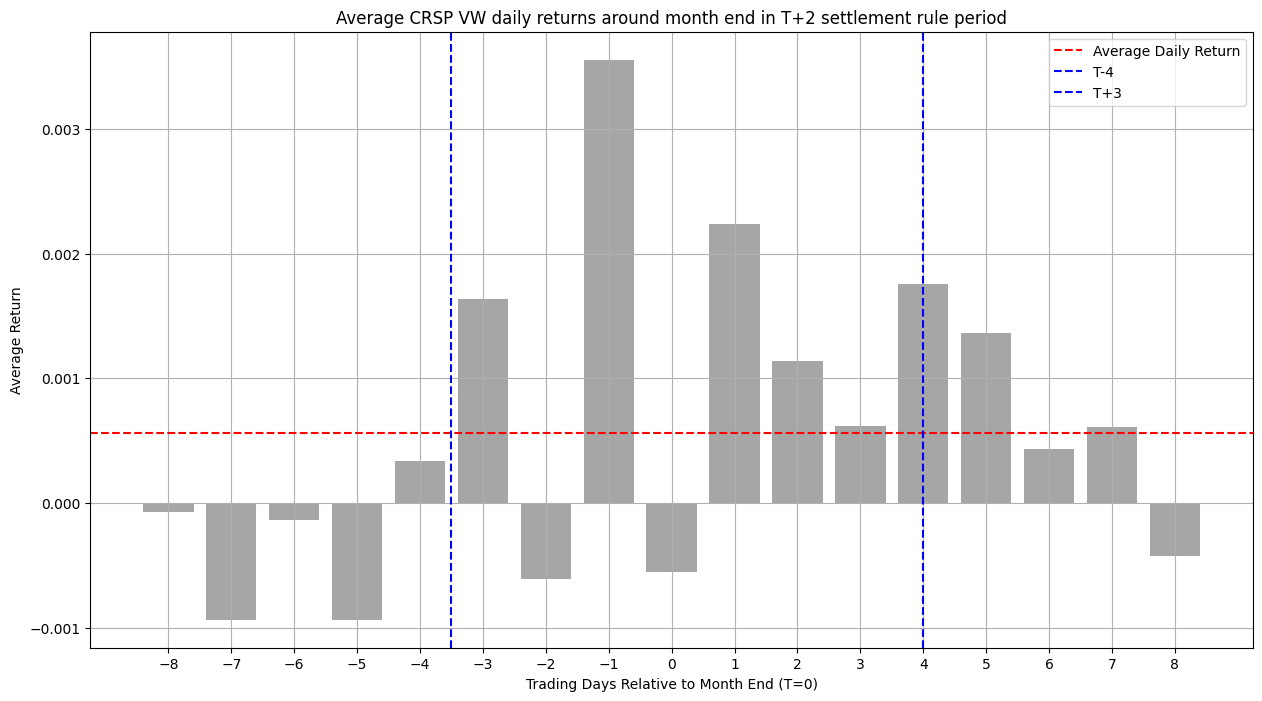

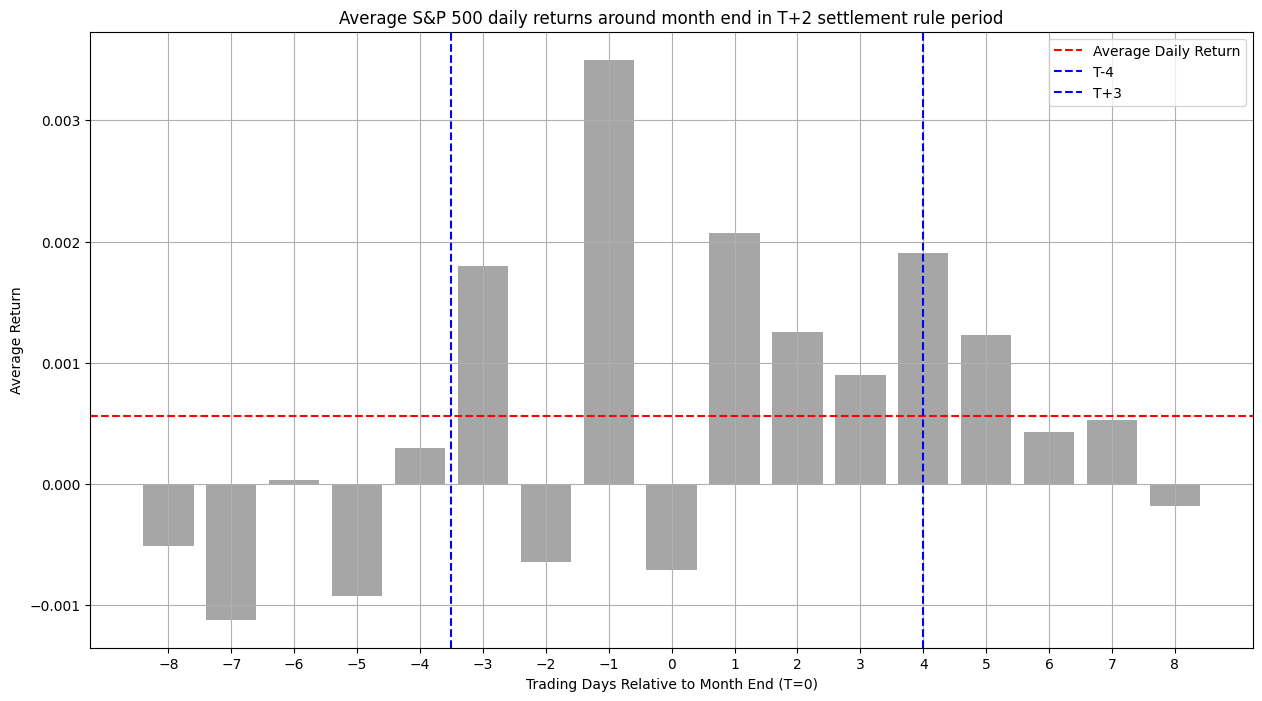

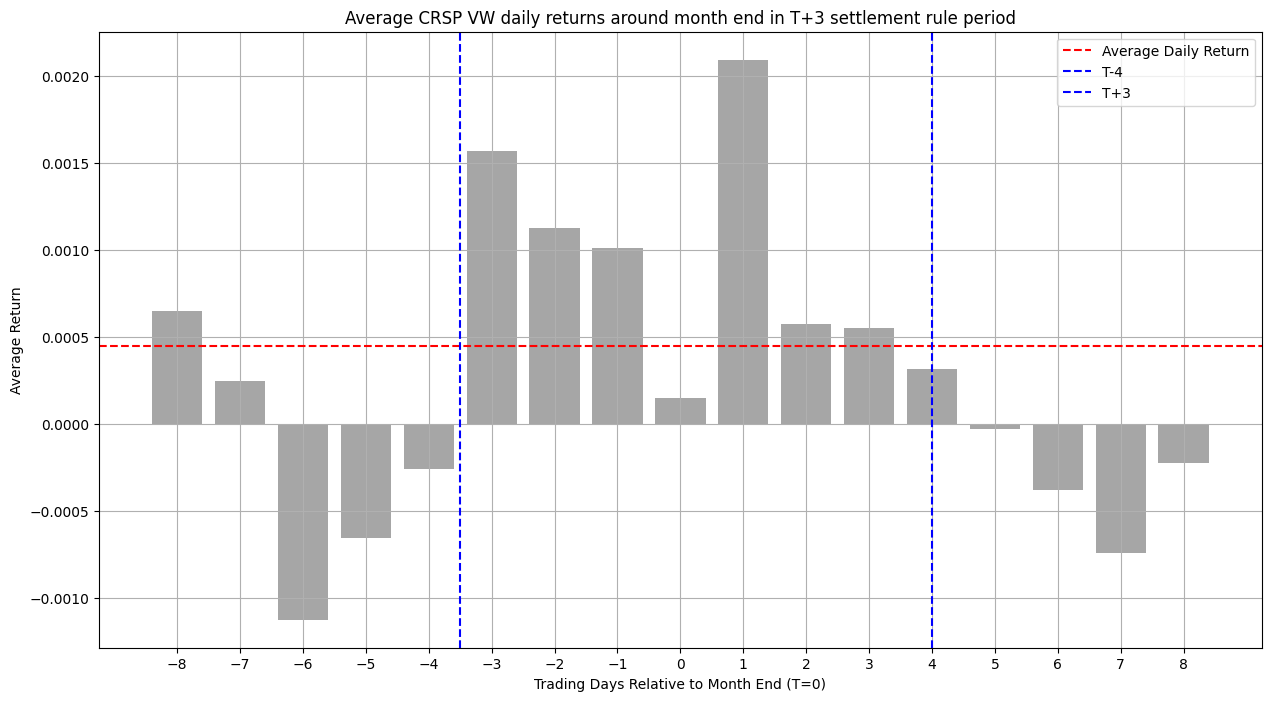

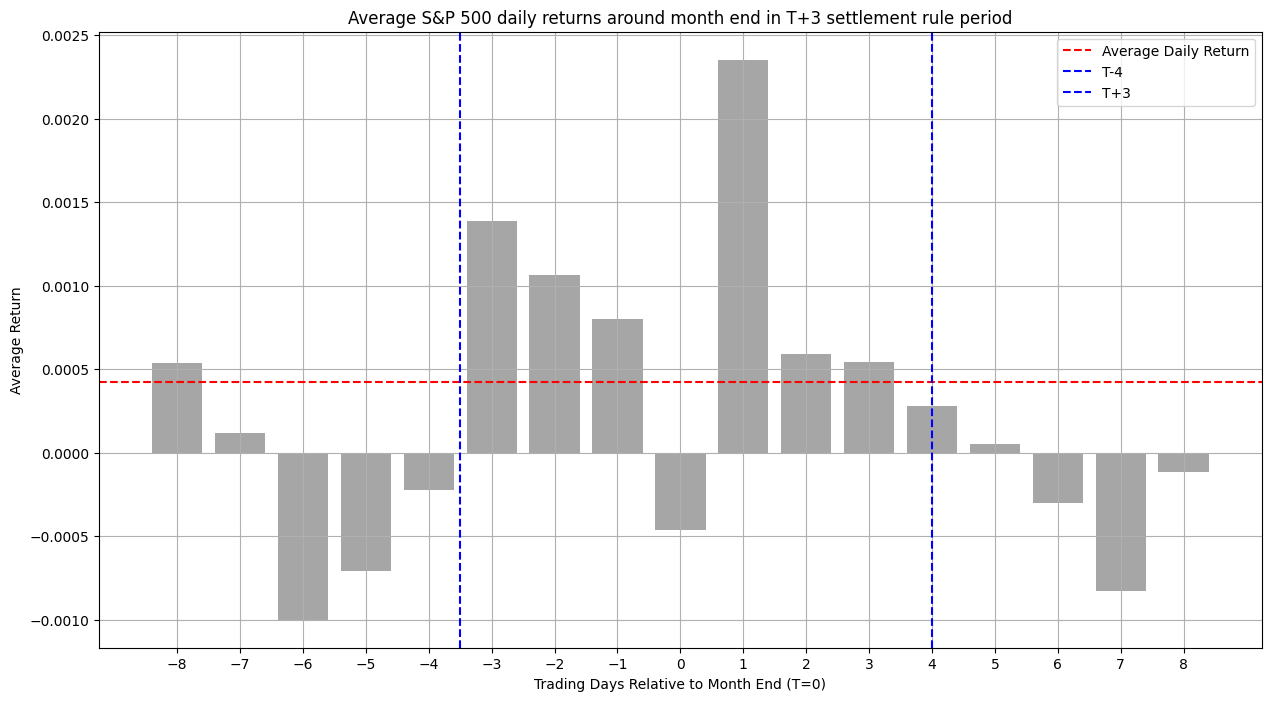

In [20]:
plot_period_returns(vw_tp2, 'Average CRSP VW daily returns around month end in T+2 settlement rule period')
plot_period_returns(sp500_tp2, 'Average S&P 500 daily returns around month end in T+2 settlement rule period')
plot_period_returns(vw_tp3, 'Average CRSP VW daily returns around month end in T+3 settlement rule period')
plot_period_returns(sp500_tp3, 'Average S&P 500 daily returns around month end in T+3 settlement rule period')

In [21]:
combine_stats = {
    ("tp3-sample", "CRSP VW"): vw_period_stats_tp3,
    ("tp3-sample", "S&P 500"): sp500_period_stats_tp3
}

# Specify the desired period order.
ordered_periods = ["T-8_to_T-4", "T-3_to_T-1", "T", "T+1_to_T+3", "T+4_to_T+8", "Average Daily Return"]

final_table = combine_stats_tables(combine_stats, ordered_periods)

# Display the final table as HTML in the Jupyter Notebook.
display(HTML(final_table.to_html(escape=False)))

In [22]:
combine_stats = {
    ("tp2-sample", "CRSP VW"): vw_period_stats_tp2,
    ("tp2-sample", "S&P 500"): sp500_period_stats_tp2
}

# Specify the desired period order.
ordered_periods = ["T-8_to_T-4", "T-3", "T-2", "T-1", "T", "T+1_to_T+3", "T+4_to_T+8", "Average Daily Return"]

final_table = combine_stats_tables(combine_stats, ordered_periods)

# Display the final table as HTML in the Jupyter Notebook.
display(HTML(final_table.to_html(escape=False)))

# Regression

**Set for periods of T+3 settlement days, control macro news announcement**

In [23]:
vw_tp3.head()

,date,ret,illiq,month,trading_day,period
0,1995-08-01,-0.004858,0.074747,1995-08,NaN,other
1,1995-08-02,-0.001937,0.058384,1995-08,NaN,other
2,1995-08-03,-0.000895,0.063041,1995-08,NaN,other
3,1995-08-04,0.001765,0.067127,1995-08,NaN,other
4,1995-08-07,0.002691,0.081519,1995-08,NaN,other


In [24]:
dummy_tp3 = (
    pd.get_dummies(vw_tp3,
                   columns=['period'],
                   prefix='',
                   prefix_sep='')
    .rename(columns={
            'T-8_to_T-4': 'sp',
            'T-3_to_T-1': 'pr',
            'T': 'me',
            'T+1_to_T+3': 'bp',
            'T+4_to_T+8': 'nr'
        })
    )
# turn of month
dummy_tp3['tom'] = dummy_tp3['trading_day'].between(-3,3).astype(int)
dummy_tp3.head()

,date,ret,illiq,month,trading_day,me,bp,nr,pr,sp,other,tom
0,1995-08-01,-0.004858,0.074747,1995-08,NaN,False,False,False,False,False,True,0
1,1995-08-02,-0.001937,0.058384,1995-08,NaN,False,False,False,False,False,True,0
2,1995-08-03,-0.000895,0.063041,1995-08,NaN,False,False,False,False,False,True,0
3,1995-08-04,0.001765,0.067127,1995-08,NaN,False,False,False,False,False,True,0
4,1995-08-07,0.002691,0.081519,1995-08,NaN,False,False,False,False,False,True,0


In [25]:
merge_data_tp3 = (
    dummy_tp3
    .merge(
        macro_dummies,
        on='date',
        how='left')
    .merge(liq_portfolio.query('bin==1').rename(columns={'portfolio_vw': 'liq'}),
           on='date',
           how='inner')
)
# Fill missing announcement dummies with 0
announcement_types = ['CPI', 'FOMC', 'Unemployment']
for atype in announcement_types:
    merge_data_tp3[atype] = merge_data_tp3[atype].fillna(0)
    
model_tp3_1 = smf.ols(
    formula='ret ~ FOMC*tom',
    data=merge_data_tp3
).fit()
model_tp3_2 = smf.ols(
    formula='ret ~ liq*tom + FOMC*tom',
    data=merge_data_tp3
).fit()

summary_table = sm_summary.summary_col(
    [model_tp3_1, model_tp3_2],
    stars=True, 
    model_names=['FOMC', 'FOMC+Liq']
)
print(summary_table)


                    FOMC    FOMC+Liq
------------------------------------
Intercept        0.0001    -0.0000  
                 (0.0002)  (0.0000) 
FOMC[T.True]     0.0040*** 0.0001   
                 (0.0012)  (0.0002) 
tom              0.0008**  0.0002***
                 (0.0003)  (0.0000) 
FOMC[T.True]:tom -0.0015   -0.0002  
                 (0.0019)  (0.0002) 
liq                        0.9783***
                           (0.0021) 
liq:tom                    -0.0058  
                           (0.0037) 
R-squared        0.0034    0.9829   
R-squared Adj.   0.0028    0.9829   
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


**Let's look at whether positioning at month end or macro news announcements would affect liquidity**

In [26]:
print(smf.ols('liq~sp+pr+me+bp+nr', merge_data_tp3).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    liq   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.953
Date:                Tue, 18 Mar 2025   Prob (F-statistic):            0.00140
Time:                        02:04:14   Log-Likelihood:                 16711.
No. Observations:                5596   AIC:                        -3.341e+04
Df Residuals:                    5590   BIC:                        -3.337e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0013      0.000      3.605      0.0

In [27]:
print(smf.ols('liq~tom*FOMC', merge_data_tp3).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                    liq   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.543
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           0.000852
Time:                        02:04:14   Log-Likelihood:                 16709.
No. Observations:                5596   AIC:                        -3.341e+04
Df Residuals:                    5592   BIC:                        -3.338e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0002      0.000  

In [28]:
# vw_dummy_tp2 = (
#     pd.get_dummies(vw_tp2,
#                    columns=['period'],
#                    prefix='',
#                    prefix_sep='')
#     .rename(columns={
#             'T-8_to_T-4': 'selling_pressure',
#             'T-3_to_T-1': 'positive_reveral',
#             'T': 'month_end',
#             'T+1_to_T+3': 'buying_pressure',
#             'T+4_to_T+8': 'negative_reversal'
#         })
#     )
# vw_dummy_tp2['turn_of_month'] = vw_dummy_tp2['trading_day'].between(-3,3).astype(int)

# Return patterns around macro news anouncement

In [29]:
import pandas as pd
import numpy as np

def analyze_macro_announcement_returns(df, window=(-2, 2), macro_var='FOMC'):
    """
    Analyze returns around macro news announcements, split by turn-of-month periods.
    
    Parameters:
    -----------
    df : DataFrame
        Merged dataframe containing:
        - 'ret': returns
        - 'trading_day': day relative to month end
        - 'tom_dummy': turn of month dummy
        - 'macro_dummy': macro news announcement dummy
        - 'date': date of observation
    window : tuple
        (start_day, end_day) for the analysis window around announcements
        
    Returns:
    --------
    DataFrame with daily returns statistics split by TOM/non-TOM periods
    """
    # Make a copy to avoid modifying original data
    data = df.copy()
    
    # Find dates with macro announcements
    macro_dates = data[data[macro_var] == 1]['date'].unique()
    
    # Create a list to store returns around each announcement
    announcement_returns = []
    
    # For each macro announcement date
    for announcement_date in macro_dates:
        # Get the window of dates around the announcement
        date_range = pd.date_range(
            start=pd.Timestamp(announcement_date) + pd.Timedelta(days=window[0]),
            end=pd.Timestamp(announcement_date) + pd.Timedelta(days=window[1])
        )
        
        # Get data for this window
        window_data = data[data['date'].isin(date_range)].copy()
        
        # Calculate days relative to announcement
        window_data['days_from_announcement'] = (
            (window_data['date'] - pd.Timestamp(announcement_date)).dt.days
        )
        
        # Add to our collection
        announcement_returns.append(window_data)
    
    # Combine all windows
    all_returns = pd.concat(announcement_returns, ignore_index=True)

    
    # Calculate statistics for each day relative to announcement, split by TOM
    def calc_stats(group):
        return pd.Series({
            'mean_ret': group['ret'].mean(),
            'std': group['ret'].std(),
            'count': len(group),
            't_stat': (group['ret'].mean() / (group['ret'].std() / np.sqrt(len(group))))
            if len(group) > 1 else np.nan
        })
    
    melt_return = (
        all_returns
        .melt(id_vars='date', 
              value_vars=['selling_pressure', 'positive_reveral', 
                          'month_end', 'buying_pressure', 'negative_reversal'],
              var_name='period',
              value_name='inperiod'
        ))
    period_return = all_returns.merge(melt_return, on='date', how='inner')
    period_return = period_return[period_return['inperiod'] == 1].copy()
    period_stats = period_return.groupby(['days_from_announcement', 'period']).apply(calc_stats).reset_index()
    whole_stats = all_returns.groupby('days_from_announcement').apply(calc_stats).reset_index()
    whole_stats['period'] = 'average_return'
    macro_stats = pd.concat([period_stats, whole_stats])
    
    
    # Calculate the difference for each period vs the average return
    diff_df = pd.DataFrame()
    for rel_day in macro_stats['days_from_announcement'].unique():
        avg_stats = (
                macro_stats.loc[(macro_stats['days_from_announcement'] == rel_day) 
                                & (macro_stats['period'] == 'average_return')].iloc[0]
            )
        for period in macro_stats['period'].unique():
            if period == 'average_return':
                continue
            period_stats = (
                macro_stats.loc[(macro_stats['days_from_announcement'] == rel_day) 
                                & (macro_stats['period'] == period)].iloc[0]
            )
            
            # Calculate pooled standard error
            if avg_stats['count'] > 1 and period_stats['count'] > 1:
                pooled_se = np.sqrt((avg_stats['std']**2/avg_stats['count']) + (period_stats['std']**2/period_stats['count']))
                diff = avg_stats['mean_ret'] - period_stats['mean_ret']
                t_stat = diff / pooled_se
            else:
                diff = avg_stats['mean_ret'] - period_stats['mean_ret']
                t_stat = np.nan
                
            diff_df.loc[rel_day, 'excess_return'] = diff
            diff_df.loc[rel_day, 't_stat'] = t_stat
            diff_df.loc[rel_day, 'period'] = period
    
    return macro_stats, diff_df

In [30]:
window = (-2, 2)
# Use your actual merged data
macro_stats, diff = analyze_macro_announcement_returns(merge_data_tp3)

print("\nDaily Return Statistics Around Macro Announcements:")
print(macro_stats.round(4))

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['selling_pressure', 'positive_reveral', 'month_end', 'buying_pressure', 'negative_reversal']"

In [214]:
print('Differences in returns around macro announcements:')
print(diff.round(4))

Differences in returns around macro announcements:
    excess_return  t_stat            period
-2         0.0029  1.4128  selling_pressure
-1        -0.0004 -0.2395  selling_pressure
 0         0.0016  0.6957  selling_pressure
 1         0.0018  0.7755  selling_pressure
 2        -0.0003 -0.1665  selling_pressure


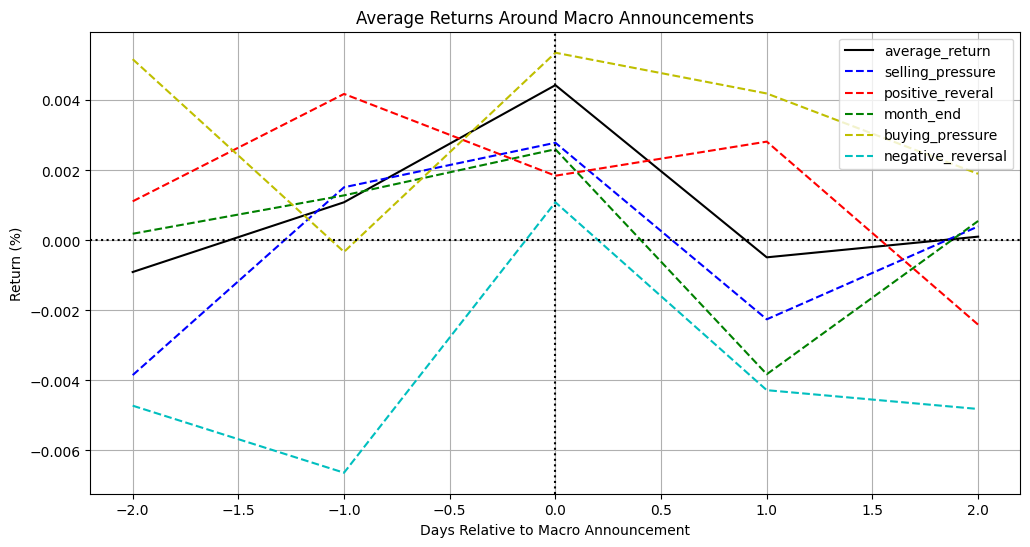

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(window[0], window[1]+1), macro_stats.loc[macro_stats['period'] == 'average_return', 'mean_ret'], 'k-', label='average_return')
plt.plot(np.arange(window[0], window[1]+1), macro_stats.loc[macro_stats['period'] == 'selling_pressure', 'mean_ret'], 'b--', label='selling_pressure')
plt.plot(np.arange(window[0], window[1]+1), macro_stats.loc[macro_stats['period'] == 'positive_reveral', 'mean_ret'], 'r--', label='positive_reveral')
plt.plot(np.arange(window[0], window[1]+1), macro_stats.loc[macro_stats['period'] == 'month_end', 'mean_ret'], 'g--', label='month_end')
plt.plot(np.arange(window[0], window[1]+1), macro_stats.loc[macro_stats['period'] == 'buying_pressure', 'mean_ret'], 'y--', label='buying_pressure')
plt.plot(np.arange(window[0], window[1]+1), macro_stats.loc[macro_stats['period'] == 'negative_reversal', 'mean_ret'], 'c--', label='negative_reversal')
plt.axhline(y=0, color='k', linestyle=':')
plt.axvline(x=0, color='k', linestyle=':')
plt.xlabel('Days Relative to Macro Announcement')
plt.ylabel('Return (%)')
plt.title('Average Returns Around Macro Announcements')
plt.legend()
plt.grid(True)
plt.show()